## Data collection and processing of the Pacific Ocean

Merging with survey for environmental data 
- Sea surface Temperature
- Degree Heating Week
- Wind speed
- Chrolophyll
- Solar Radiation
- PAR (Photosynthetically Active Radiation)
- Ocean Depth 

+ ++++++
- Distance to Port

In [1]:
# Importing packages
import gdal
import pandas as pd
import numpy as np
import geopandas as gpd
from io import StringIO
from shapely.geometry import Point
import osr
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
import seaborn as sns
import os
import sys
import glob
sys.path.insert(0, os.path.abspath(''))

import data_processing_helper as dp
import practical_functions as pf
import xarray as xr
import pygrib
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import netCDF4 as nc
import requests as rq
import shapely
from shapely import wkt
from shapely.wkt import loads
from osgeo import gdal
plt.style.use('ggplot') # use ggplot style

/home/lavinia/.local/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


## Loading the Shapefiles for the Pacific

In [2]:
gdf_AUS = gpd.read_file('../Data/Reefs/shp_GBR/Reefs_GBR.shp')
drop_cols_shape = ['left', 'top', 'right', 'bottom', 'AREA']
gdf_IND = gpd.read_file('../Data/Reefs/shp_indonesia/indonesia.shp').drop(columns = drop_cols_shape)
gdf_TLS = gpd.read_file('../Data/Reefs/shp_timorleste/timorleste.shp').drop(columns = drop_cols_shape)
gdf_SLB = gpd.read_file('../Data/Reefs/shp_solomon/solomon.shp').drop(columns = drop_cols_shape)

# Combining the shapefiles
gdf_PAC = gpd.GeoDataFrame(pd.concat([gdf_AUS, gdf_IND, gdf_TLS, gdf_SLB]))

## Loading the Survey folder
It contains the coordinates of the Survey and the percentage of algae, corals, soft_corals or other_invertebrates


In [3]:
Survey_global = pd.read_csv("../Data/Reefs/seaviewsurvey_surveys.csv")
Survey_global.head()

,surveyid,transectid,surveydate,ocean,country,folder_name,lat_start,lng_start,lat_end,lng_end,pr_hard_coral,pr_algae,pr_soft_coral,pr_oth_invert,pr_other
0,10001,10001,20120916,PAC,AUS,PAC_AUS_10001_201209,-16.189023,145.898104,-16.191761,145.894088,0.1856,0.3724,0.2710,0.0010,0.1700
1,10002,10002,20120917,PAC,AUS,PAC_AUS_10002_201209,-16.189303,145.898254,-16.175947,145.889736,0.1364,0.4766,0.3079,0.0020,0.0771
2,10003,10003,20120918,PAC,AUS,PAC_AUS_10003_201209,-16.175768,145.891676,-16.181218,145.888904,0.2475,0.5653,0.0747,0.0207,0.0917
3,10004,10004,20120920,PAC,AUS,PAC_AUS_10004_201209,-16.536645,147.806796,-16.524287,147.843325,0.1242,0.5706,0.0279,0.0023,0.2748
4,10005,10005,20120920,PAC,AUS,PAC_AUS_10005_201209,-16.529216,147.802582,-16.521689,147.836180,0.0781,0.7894,0.0096,0.0029,0.1201


In [4]:
Survey = Survey_global[(Survey_global["country"] == "AUS") | (Survey_global["country"] == "IDN") | (Survey_global["country"] == "TLS")| (Survey_global["country"] == "SLB")]
print("We now have a total of :",Survey.shape[0], " Surveys")
Survey.head()

We now have a total of : 421  Surveys


,surveyid,transectid,surveydate,ocean,country,folder_name,lat_start,lng_start,lat_end,lng_end,pr_hard_coral,pr_algae,pr_soft_coral,pr_oth_invert,pr_other
0,10001,10001,20120916,PAC,AUS,PAC_AUS_10001_201209,-16.189023,145.898104,-16.191761,145.894088,0.1856,0.3724,0.2710,0.0010,0.1700
1,10002,10002,20120917,PAC,AUS,PAC_AUS_10002_201209,-16.189303,145.898254,-16.175947,145.889736,0.1364,0.4766,0.3079,0.0020,0.0771
2,10003,10003,20120918,PAC,AUS,PAC_AUS_10003_201209,-16.175768,145.891676,-16.181218,145.888904,0.2475,0.5653,0.0747,0.0207,0.0917
3,10004,10004,20120920,PAC,AUS,PAC_AUS_10004_201209,-16.536645,147.806796,-16.524287,147.843325,0.1242,0.5706,0.0279,0.0023,0.2748
4,10005,10005,20120920,PAC,AUS,PAC_AUS_10005_201209,-16.529216,147.802582,-16.521689,147.836180,0.0781,0.7894,0.0096,0.0029,0.1201


In [5]:
# Change date format 
Survey['surveydate'] = pd.to_datetime(Survey['surveydate'], format='%Y%m%d')

In [6]:
# Make pacific survey into GeoDataFrame
gSurvey = gpd.GeoDataFrame(Survey, geometry = gpd.points_from_xy(Survey.lat_start, Survey.lng_start))
gSurvey["country"].value_counts()

AUS    261
IDN    114
TLS     26
SLB     20
Name: country, dtype: int64

We can see that most surveys were taken in Australia followed by Indonesia. With a total of 421 surveys

In [7]:
# Keep only month and year
gSurvey['surveydate'] = gSurvey['surveydate'].dt.strftime('%Y-%m')

## Wind speed
https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels-monthly-means?tab=form


For these coordinates:


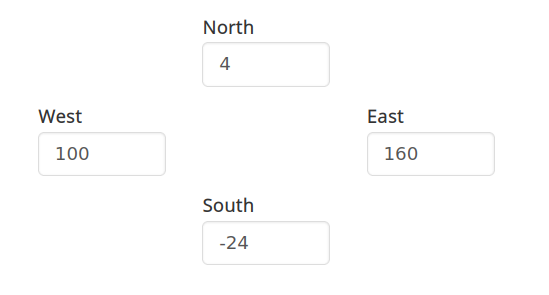



**Be careful, various users have stated how slow this download is** : https://confluence.ecmwf.int/pages/viewpage.action?pageId=143050283



In [36]:
# Load xarray
ds_wind = xr.open_dataset("../Data/Environmental_data/wind_monthly.nc")

# Make dataframe
df_wind = ds_wind.to_dataframe()

# Rename and reset longitude and latitude index
df_wind.rename(columns = {"si10":"wind_speed"}, inplace = True)

df_indx = df_wind.copy()

In [37]:
df_wind.reset_index(inplace = True)

# Make into GeoDataFrame
gdf_wind = gpd.GeoDataFrame(df_wind, geometry=gpd.points_from_xy(df_wind.latitude, df_wind.longitude))

# Keep only month and year
gdf_wind["time"] = gdf_wind["time"].dt.strftime('%Y-%m')

In [10]:
# Drop unecessary columns
gdf_wind.drop(columns = ['latitude', 'longitude', 'number', 'step', 'surface',
       'valid_time'], inplace = True)
gSurvey.drop(columns = ['surveyid', 'ocean', 
       'folder_name', 'lat_end', 'lng_end',
       'pr_hard_coral', 'pr_algae', 'pr_soft_coral', 'pr_oth_invert',
       'pr_other'], inplace = True)

In [11]:
# Look at the dates which are unique within the survey (month and year)
dates_surveys = gSurvey['surveydate'].unique()

In [67]:
# Looping through the different dates and places and find the closest wind speed at each Survey point
frames_all = dp.merge_(gSurvey,gdf_wind, dates_surveys)

In [68]:
# Add wind_speed to geoframe
gSurvey["wind_speed"] = frames_all["wind_speed"].to_list()

In [69]:
Survey.drop(columns = ['surveyid', 'ocean', 'country',
       'folder_name', 'lat_start', 'lng_start', 'lat_end', 'lng_end',
        'geometry'], inplace = True)

In [117]:
# Merge with Survey
df_merge_w = pd.merge(Survey, gSurvey,on = ["surveydate","transectid"], how = "left")

In [71]:
dups_sur_trans = df_merge_w.pivot_table(index=['surveydate','transectid'], aggfunc='size')
print (dups_sur_trans.value_counts())
print("You have 5 surveys with 4 duplicates...remove to ease computation")

1    411
4      5
dtype: int64
You have 5 surveys with 4 duplicates...remove to ease computation


In [72]:
dups_sur_trans[dups_sur_trans == 4]

surveydate  transectid
2014-05     12029         4
2018-06     32003         4
            32024         4
            32026         4
            32030         4
dtype: int64

In [143]:
# Here I drop the duplicates on time and transectid, indeed I could just take the mean of them instead of 
# keeping only first value
df_mer_w = df_merge_w.drop_duplicates(subset=["surveydate","transectid"], keep="first", inplace = False)

In [75]:
def ck(gdA, gdB):

    nA = np.array(list(gdA.geometry.apply(lambda x: (x.x, x.y))))
    nB = np.array(list(gdB.geometry.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(nB)
    dist, idx = btree.query(nA, k=1)
    gdB_nearest = gdB.iloc[idx].drop(columns="geometry").reset_index(drop=True)
    
    gdf = pd.concat(
        [
            
            gdA.reset_index(drop=True),
            gdB_nearest,
            pd.Series(dist, name='dist')
            
        ], 
        axis=1)

    return [gdf, pd.Series(gdB.iloc[idx]["geometry"], name ="geo_wind")]
def me(df_survey, df_env, surv_list):
    
    df = []
    ID = []
    for date in surv_list:
       
        df_envv = df_env[df_env["time"] == date]
        df_sur = df_survey[df_survey['surveydate'] == date]
        df_ , idx= ck(df_sur, df_envv)
        df.append(df_)
        ID.append(idx)

        
    return [pd.concat(df), ID, df]

In [108]:

df_mer_w_ = pf.make_geo_frame(df_mer_w)

In [109]:
# Looping through the different dates and places and find the closest wind speed at each Survey point
frames, index, df_frame = me(df_mer_w_,gdf_wind, dates_surveys)

In [110]:
df = []
for i in range(len(df_frame)):
    index[i].index = np.arange(0, len(index[i]))
    df.append(pd.merge(df_frame[i], index[i], how = "outer",on = index[i].index))
    
df_wind_geo = pd.concat(df)
df_wind_geo.index = np.arange(0, len(df_wind_geo))    

In [111]:
lat_wind = df_wind_geo["geo_wind"].x
lon_wind = df_wind_geo["geo_wind"].y

In [113]:
df_wind.drop(columns = ["geometry", "surface", "step", "number", "valid_time"], inplace = True)
df_wind_eval = []

for i in range(len(lat_wind)):
    df = df_wind.query(format(f'latitude == {lat_wind[i]} and longitude == {lon_wind[i]}'))
    df.drop(columns = ["latitude", "longitude"], inplace = True)
    df.set_index("time", inplace = True)
    df = df.transpose()
    df_wind_eval.append(df)
    

In [ ]:
df_wind_eval = pd.concat(df_wind_eval)
df_wind_eval = df_wind_eval.add_prefix("wind_")

In [145]:
df_wind_eval.index = np.arange(0, len(df_wind_eval))
df_mer_w.index = np.arange(0, len(df_mer_w))

In [146]:
df_mer_w_extended = pd.concat([df_mer_w, df_wind_eval], axis=1)

In [147]:
df_mer_w_extended

,transectid,surveydate,pr_hard_coral,pr_algae,pr_soft_coral,pr_oth_invert,pr_other,country,lat_start,lng_start,...,wind_2020-05,wind_2020-06,wind_2020-07,wind_2020-08,wind_2020-09,wind_2020-10,wind_2020-11,wind_2020-12,wind_2021-01,wind_2021-02
0,10001,2012-09,0.1856,0.3724,0.2710,0.0010,0.1700,AUS,-16.189023,145.898104,...,9.896668,10.430840,10.155021,7.587570,9.797705,7.150857,7.645367,5.195395,7.099016,5.238227
1,10002,2012-09,0.1364,0.4766,0.3079,0.0020,0.0771,AUS,-16.189303,145.898254,...,9.896668,10.430840,10.155021,7.587570,9.797705,7.150857,7.645367,5.195395,7.099016,5.238227
2,10003,2012-09,0.2475,0.5653,0.0747,0.0207,0.0917,AUS,-16.175768,145.891676,...,9.896668,10.430840,10.155021,7.587570,9.797705,7.150857,7.645367,5.195395,7.099016,5.238227
3,10004,2012-09,0.1242,0.5706,0.0279,0.0023,0.2748,AUS,-16.536645,147.806796,...,9.028993,9.621758,9.076407,7.068527,8.755224,6.695291,7.254742,5.013266,6.002824,5.046089
4,10005,2012-09,0.0781,0.7894,0.0096,0.0029,0.1201,AUS,-16.529216,147.802582,...,9.028993,9.621758,9.076407,7.068527,8.755224,6.695291,7.254742,5.013266,6.002824,5.046089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411,32022,2018-06,0.0664,0.7374,0.0306,0.0368,0.1291,IDN,1.679154,125.177118,...,2.615419,2.884941,3.657950,4.064132,3.120947,2.691385,2.947124,3.282553,3.799211,4.004341
412,32023,2018-06,0.1148,0.4541,0.0658,0.0307,0.3346,IDN,1.671353,125.133216,...,2.615419,2.884941,3.657950,4.064132,3.120947,2.691385,2.947124,3.282553,3.799211,4.004341
413,32012,2018-06,0.0587,0.5438,0.0504,0.0512,0.2962,IDN,1.734514,125.150193,...,2.615419,2.884941,3.657950,4.064132,3.120947,2.691385,2.947124,3.282553,3.799211,4.004341
414,32010,2018-06,0.0373,0.6490,0.0072,0.0157,0.2908,IDN,1.836848,125.146803,...,2.615419,2.884941,3.657950,4.064132,3.120947,2.691385,2.947124,3.282553,3.799211,4.004341


## Chlorophyll Copernicus



In [ ]:
import cdsapi
def import_chloro(year_list, name):
    c = cdsapi.Client()

    c.retrieve(
        'satellite-ocean-colour',
        {
            'format': 'tgz',
            'variable': 'mass_concentration_of_chlorophyll_a',
            'projection': 'regular_latitude_longitude_grid',
            'year': year_list,
            'month': [
                '01', '02', '03',
                '04', '05', '06',
                '07', '08', '09',
                '10', '11', '12',
            ],
            'day': '01',
            'version': '5.0',
        },
        '%s.tar.gz' %name)


import_chloro(["2012", "2014"], "chlorophyll_12_14")
import_chloro(["2016", "2017"], "chlorophyll_16_17")
import_chloro(["2018"], "chlorophyll_18")

In [155]:
ds_chlor = xr.open_mfdataset("../Data/Environmental_data/chlorophyll/ESACCI-OC-L3S-CHLOR_A-MERGED-1D_DAILY_4km*.nc")

In [156]:
# Bounds of coordinates for Pacific
latbounds = [-24, 4]
lonbounds = [100, 160]
lats = ds_chlor.variables["lat"][:]
lons = ds_chlor.variables["lon"][:]
# latitude lower and upper index
latli = np.argmin( np.abs( lats - latbounds[0] ).values )
latui = np.argmin( np.abs( lats - latbounds[1] ).values ) 
# longitude lower and upper index
lonli = np.argmin( np.abs( lons - lonbounds[0] ).values )
lonui = np.argmin( np.abs( lons - lonbounds[1] ).values )  



In [ ]:
# Subset for the given coordinates
ChlorSubset = ds_chlor.variables['chlor_a'][ : , latui:latli , lonli:lonui ] 
# Dataset with the chlor amongst the different coordinates
ds_sub_chlor = xr.Dataset(data_vars={"Chlor": ChlorSubset}, coords = {"lon":ds_chlor["lon"][lonli:lonui], "lat": ds_chlor["lat"][latui:latli], "time":ds_chlor["time"]})
df_chlor = ds_sub_chlor.to_dataframe()

df_chlor.reset_index(inplace = True)

# remove the Nan values, so that it automatically takes the existing values as closest to the survey points
df_chlor = df_chlor.dropna(axis = 0)

In [ ]:
# Save as intermediate 
df_chlor.to_csv("../Data/Environmental_data/df_chlor.csv", index = False)

df_chlor = pd.read_csv("../Data/Environmental_data/df_chlor.csv")
# Change to datetime format
df_chlor['time'] = pd.to_datetime(df_chlor['time'], errors='coerce')


# Keep only month and year 
df_chlor["time"] = df_chlor["time"].dt.strftime('%Y-%m')
gdf_chlor = gpd.GeoDataFrame(df_chlor, geometry=gpd.points_from_xy(df_chlor.lat, df_chlor.lon))

# Merge with the previous frame 
df_merged_w_ch = dp.merge_(df_mer_w, gdf_chlor, dates_surveys)


df_mer_w["Chlor"] = df_merged_w_ch["Chlor"].to_list()
df_merged_w_ch = df_mer_w

df_merged_w_ch.to_csv("../Data/Environmental_data/merged_wind_chlor.csv", index = False)
df_merged_w_ch = pd.read_csv("../Data/Environmental_data/merged_wind_chlor.csv")

# Change the "geometry" column to geometry type
dp.geo_loads(df_merged_w_ch)


In [157]:
df_merged_w_ch = pd.read_csv("../Data/Environmental_data/merged_wind_chlor.csv")

# Change the "geometry" column to geometry type
dp.geo_loads(df_merged_w_ch)

## Solar radiation Copernicus


In [ ]:
c = cdsapi.Client()

c.retrieve(
    'reanalysis-era5-single-levels-monthly-means',
    {
        'format': 'grib',
        'product_type': 'monthly_averaged_reanalysis',
        'variable': [
            'surface_net_solar_radiation', 'surface_net_solar_radiation_clear_sky',
        ],
        'year': [
            '2012', '2013', '2014',
            '2015', '2016', '2017',
            '2018',
        ],
        'month': [
            '01', '02', '03',
            '04', '05', '06',
            '07', '08', '09',
            '10', '11', '12',
        ],
        'time': '00:00',
        'area': [
            4, 100, -24,
            160,
        ],
    },
    'download.grib')

In [ ]:

ds_solar = xr.open_dataset("../Data/Environmental_data/solar_radiation.grib", engine = "cfgrib")
cdf_solar = ds_solar.to_netcdf("../Data/Environmental_data/solar_rad.nc")


In [158]:
# Load xarray
ds_solar = xr.open_dataset("../Data/Environmental_data/solar_rad.nc")

In [159]:
# Surface net solar radiation, clear sky :: SSRC [J m**-2]
# Surface net solar radiation :: SSR [J m**-2]
# Make dataframe
df_solar = ds_solar.to_dataframe()

# Rename and reset longitude and latitude index
df_solar.rename(columns = {"ssr":"solar_rad", "ssrc":"solar_rad_clear_sky"}, inplace = True)

df_solar_indx = df_solar.copy()
df_solar.reset_index(inplace = True)

df_solar.drop(columns = ['number','time', 'step', 'surface'], inplace = True)


# Keep only month and year 
df_solar["valid_time"] = df_solar["valid_time"].dt.strftime('%Y-%m')

gdf_solar = gpd.GeoDataFrame(df_solar, geometry=gpd.points_from_xy(df_solar.latitude, df_solar.longitude))
gdf_solar.rename(columns = {"valid_time" : "time"}, inplace = True)

df_merged_w_ch_sol = dp.merge_(df_merged_w_ch, gdf_solar, dates_surveys)


In [169]:
df_solar_indx.reset_index("time", inplace = True)

In [170]:
df_solar_indx["time"] = df_solar_indx["time"].dt.strftime('%Y-%m')

In [162]:
df_merged_w_ch_sol_ = pf.make_geo_frame(df_merged_w_ch_sol)

In [163]:
# Looping through the different dates and places and find the closest wind speed at each Survey point
frames, index, df_frame = me(df_merged_w_ch_sol_,gdf_wind, dates_surveys)

In [164]:
df = []
for i in range(len(df_frame)):
    index[i].index = np.arange(0, len(index[i]))
    df.append(pd.merge(df_frame[i], index[i], how = "outer",on = index[i].index))
    
df_solar_geo = pd.concat(df)
df_solar_geo.index = np.arange(0, len(df_solar_geo))    

In [165]:
lat_solar= df_solar_geo["geo_wind"].x
lon_solar = df_solar_geo["geo_wind"].y

In [180]:
df_solar.drop(columns = ["geometry"], inplace = True)
df_solar_eval = []

for i in range(len(lat_wind)):
    df = df_solar.query(format(f'latitude == {lat_solar[i]} and longitude == {lon_solar[i]}'))
    df.drop(columns = ["latitude", "longitude"], inplace = True)
    df.set_index("time", inplace = True)
    df = df.transpose()
    df_solar_eval.append(df)
    

In [181]:
df_solar_eval = pd.concat(df_solar_eval)
df_solar_eval = df_solar_eval.add_prefix("solar_")

In [182]:
df_merged_w_ch["solar_rad"] = df_merged_w_ch_sol["solar_rad"].to_list()
df_merged_w_ch["solar_rad_clear_sky"] = df_merged_w_ch_sol["solar_rad_clear_sky"].to_list()
df_merged_w_ch_sol = df_merged_w_ch

In [183]:
df_merged_w_ch_sol.to_csv("../Data/Environmental_data/merged_wind_chlor_sol.csv", index = False)
df_merged_w_ch_sol = pd.read_csv("../Data/Environmental_data/merged_wind_chlor_sol.csv")

In [188]:
df_solar_rad = df_solar_eval.loc["solar_rad"]
df_solar_rad_clear = df_solar_eval.loc["solar_rad_clear_sky"]

In [191]:
df_solar_rad_clear = df_solar_rad_clear.add_prefix("clear_rad_")
df_solar_rad = df_solar_rad.add_prefix("rad_")
df_solar_rad_clear.index = np.arange(0, len(df_solar_rad_clear))
df_solar_rad.index = np.arange(0, len(df_solar_rad))

In [196]:


df_extended = pd.concat([df_mer_w_extended, df_solar_rad, df_solar_rad_clear], axis=1)

## Ocean depth Copernicus // Sentinel 3

Ocean level, so negative numbers are for below water :)

In [201]:
# Load xarray for depth
ds_depth = xr.open_dataset("../Data/Environmental_data/depth/depth.nc")

# Set latitude and longitude as index
df_merged_w_ch_sol_ind = df_merged_w_ch_sol.set_index(["lat_start", "lng_start"])

# Make a NetCDF with the multi-index dataframe 
xr_merged = xr.Dataset.from_dataframe(df_merged_w_ch_sol_ind)
xr_merged = xr_merged.rename({"lat_start" : "lat"})
xr_merged= xr_merged.rename({"lng_start" : "lon"})


# Keep interesting lat/long
long_ = [xr_merged["lon"].values]
latg_ = [xr_merged["lat"].values]

# Find nearest depth to the given lat/lon
df_depth_near = ds_depth.sel(lon=long_[0], lat=latg_[0], method='nearest')

# Assign the coordinates of interst as coordinates in NetCdf
depth_same_coord = df_depth_near.assign_coords(lon = long_[0], lat = latg_[0])
xr_merged_depth = xr_merged.merge(depth_same_coord, join = "inner")

df_depth_merged = xr_merged_depth.to_dataframe()


In [202]:
# Drop nan values for unknown depths and reset index (lat,lon)
df_merged = df_depth_merged.dropna().reset_index()

### Degree Heating Week 

In [203]:
def treat_SST_DHW(df, gdf):
    df["id"] = df["id"].str.replace('R', "").astype(int)
    
    df = df.merge(gdf[["id", "geometry"]], how='left')
    df.dropna(inplace = True)
    
    df_temp = df.drop(columns = ["id", "geometry"])
    df_temp.columns = pd.to_datetime(df_temp.columns)
    df_temp.columns = df_temp.columns.strftime("%Y-%m")
    df_temp.insert(0, "id", df["id"])
    df_temp.insert(0, "geometry", df["geometry"])
    df = df_temp.copy()
    df = pf.make_geo_frame(df)
    return df
    
    
    

In [204]:
DHW_IDN = pd.read_csv("../Data/Environmental_data/DHW/DHW_Indonesia.csv")

In [205]:
DHW_IDN.head()
DHW_IDN = treat_SST_DHW(DHW_IDN, gdf_IND)

In [206]:
# Degree Heating week and SST for Indonesia

DHW_IDN = pd.read_csv("../Data/Environmental_data/DHW/DHW_Indonesia.csv")
DHW_IDN = treat_SST_DHW(DHW_IDN, gdf_IND)
dp.geo_loads(df_merged)
SST_IDN = pd.read_csv("../Data/Environmental_data/SST/SST_Indonesia.csv")
SST_IDN = treat_SST_DHW(SST_IDN, gdf_IND)
df_merged = pf.make_geo_frame(df_merged)

In [207]:
df_swap = df_merged.copy()
# Swap the coordinates 
df_swap["geometry"] = df_swap.geometry.map(lambda polygon: shapely.ops.transform(lambda x, y: (y, x), polygon))

In [208]:
# Take the intersection
# nothing in common...
DHW_merged_IDN = gpd.sjoin(DHW_IDN, df_swap[df_swap["country"] == "IDN"], how="inner", op='intersects')
print("DHW merged: ", DHW_merged_IDN.shape)
SST_merged_IDN = gpd.sjoin(SST_IDN, df_swap[df_swap["country"] == "IDN"], how="inner", op='intersects')
print("SST merged: ", SST_merged_IDN.shape)

DHW merged:  (0, 447)
SST merged:  (0, 447)


In [209]:
# Let us use another strategy. I will take the centroid of the polygon and estimate the closests neighbor
DHW_IDN.geometry = DHW_IDN['geometry'].centroid
df_near_merge_IDN_DHW = dp.ckdnearest(df_swap[df_swap["country"] == "IDN"], DHW_IDN).drop(columns = "dist")

SST_IDN.geometry = SST_IDN['geometry'].centroid
df_near_merge_IDN_SST = dp.ckdnearest(df_swap[df_swap["country"] == "IDN"], SST_IDN).drop(columns = "dist")

In [210]:
# Same for both SST and DHW
dates_to_drop = df_near_merge_IDN_DHW.columns[17:][df_near_merge_IDN_DHW.columns[17:].isin(df_near_merge_IDN_DHW["surveydate"]) == False]
dates_to_keep = df_near_merge_IDN_DHW.columns[17:][df_near_merge_IDN_DHW.columns[17:].isin(df_near_merge_IDN_DHW["surveydate"])]
df_near_merge_IDN_SST.drop(columns = dates_to_drop,  inplace = True)
df_near_merge_IDN_DHW.drop(columns = dates_to_drop,  inplace = True)

In [211]:
df_near_merge_IDN_DHW['DHW'] = df_near_merge_IDN_DHW.lookup(df_near_merge_IDN_DHW.index, df_near_merge_IDN_DHW['surveydate'].astype(str))
df_near_merge_IDN_DHW.drop(columns = dates_to_keep,  inplace = True)
df_near_merge_IDN_SST['SST'] = df_near_merge_IDN_SST.lookup(df_near_merge_IDN_SST.index, df_near_merge_IDN_SST['surveydate'].astype(str))
df_near_merge_IDN_SST.drop(columns = dates_to_keep,  inplace = True)

In [212]:
df_near_merge_IDN = df_near_merge_IDN_DHW.copy()
df_near_merge_IDN["SST"] = df_near_merge_IDN_SST['SST']

# Indonesia done

In [215]:
# Same for Timor Leste
# Degree Heating week and SST
DHW_TLS = pd.read_csv("../Data/Environmental_data/DHW/DHW_Timor.csv")
DHW_TLS = treat_SST_DHW(DHW_TLS, gdf_TLS)
SST_TLS = pd.read_csv("../Data/Environmental_data/SST/SST_Timor.csv")
SST_TLS = treat_SST_DHW(SST_TLS, gdf_TLS)

In [216]:
#  Nothing in common
DHW_merged_TLS = gpd.sjoin(DHW_TLS, df_swap[df_swap["country"] == "TLS"], how="inner", op='intersects')
print("DHW merged: ", DHW_merged_TLS.shape)
SST_merged_TLS = gpd.sjoin(SST_TLS, df_swap[df_swap["country"] == "TLS"], how="inner", op='intersects')
print("SST merged: ", SST_merged_TLS.shape)

DHW merged:  (0, 447)
SST merged:  (0, 447)


In [217]:
# Same centroid strategy
DHW_TLS.geometry = DHW_TLS['geometry'].centroid
df_near_merge_TLS_DHW = dp.ckdnearest(df_swap[df_swap["country"] == "TLS"], DHW_TLS)

SST_TLS.geometry = SST_TLS['geometry'].centroid
df_near_merge_TLS_SST = dp.ckdnearest(df_swap[df_swap["country"] == "TLS"], SST_TLS)


In [218]:
# Same for both SST and DHW
dates_to_drop = df_near_merge_TLS_DHW.columns[17:][df_near_merge_TLS_DHW.columns[17:].isin(df_near_merge_TLS_DHW["surveydate"]) == False]
dates_to_keep = df_near_merge_TLS_DHW.columns[17:][df_near_merge_TLS_DHW.columns[17:].isin(df_near_merge_TLS_DHW["surveydate"])]
df_near_merge_TLS_SST.drop(columns = dates_to_drop,  inplace = True)
df_near_merge_TLS_DHW.drop(columns = dates_to_drop,  inplace = True)

In [219]:
df_near_merge_TLS_DHW['DHW'] = df_near_merge_TLS_DHW.lookup(df_near_merge_TLS_DHW.index, df_near_merge_TLS_DHW['surveydate'].astype(str))
df_near_merge_TLS_DHW.drop(columns = dates_to_keep,  inplace = True)
df_near_merge_TLS_SST['SST'] = df_near_merge_TLS_SST.lookup(df_near_merge_TLS_SST.index, df_near_merge_TLS_SST['surveydate'].astype(str))
df_near_merge_TLS_SST.drop(columns = dates_to_keep,  inplace = True)
df_near_merge_TLS = df_near_merge_TLS_DHW.copy()
df_near_merge_TLS["SST"] = df_near_merge_TLS_SST['SST']
df_near_merge_TLS.head(2)

,lat,lon,transectid,surveydate,pr_hard_coral,pr_algae,pr_soft_coral,pr_oth_invert,pr_other,country,geometry,wind_speed,Chlor,solar_rad,solar_rad_clear_sky,elevation,id,DHW,SST
0,-9.186476,124.391635,30023.0,2014-07,0.2536,0.3902,0.1027,0.0472,0.2063,TLS,POINT (124.39163 -9.18648),3.709066,0.406888,16667136.0,18682368.0,-85,17651,0.0,27.668065
1,-9.173817,124.409284,30022.0,2014-07,0.1146,0.3139,0.0755,0.0350,0.4609,TLS,POINT (124.40928 -9.17382),3.709066,0.406888,16667136.0,18682368.0,-15,17651,0.0,27.668065


In [222]:
# Solomon
# Degree Heating week and SST
DHW_SLB = pd.read_csv("../Data/Environmental_data/DHW/DHW_Indonesia.csv")
DHW_SLB = treat_SST_DHW(DHW_SLB, gdf_SLB)
SST_SLB = pd.read_csv("../Data/Environmental_data/SST/SST_Solomon.csv")
SST_SLB = treat_SST_DHW(SST_SLB, gdf_SLB)

In [223]:
# Nothing in common for DHW and 11 for SST
DHW_merged_SLB = gpd.sjoin(DHW_SLB, df_swap[df_swap["country"] == "SLB"], how="inner", op='intersects')
print("DHW merged: ", DHW_merged_SLB.shape)
SST_merged_SLB = gpd.sjoin(SST_SLB, df_swap[df_swap["country"] == "SLB"], how="inner", op='intersects')
print("SST merged: ", SST_merged_SLB.shape)

DHW merged:  (0, 447)
SST merged:  (11, 447)


In [224]:
# Same
DHW_SLB.geometry = DHW_SLB['geometry'].centroid
df_near_merge_SLB_DHW = dp.ckdnearest(df_swap[df_swap["country"] == "SLB"], DHW_SLB)
SST_SLB.geometry = SST_SLB['geometry'].centroid
df_near_merge_SLB_SST = dp.ckdnearest(df_swap[df_swap["country"] == "SLB"], SST_SLB)


In [225]:
# Same for both SST and DHW
dates_to_drop = df_near_merge_SLB_DHW.columns[17:][df_near_merge_SLB_DHW.columns[17:].isin(df_near_merge_SLB_DHW["surveydate"]) == False]
dates_to_keep = df_near_merge_SLB_DHW.columns[17:][df_near_merge_SLB_DHW.columns[17:].isin(df_near_merge_SLB_DHW["surveydate"])]
df_near_merge_SLB_SST.drop(columns = dates_to_drop,  inplace = True)
df_near_merge_SLB_DHW.drop(columns = dates_to_drop,  inplace = True)

In [226]:
df_near_merge_SLB_DHW['DHW'] = df_near_merge_SLB_DHW.lookup(df_near_merge_SLB_DHW.index, df_near_merge_SLB_DHW['surveydate'].astype(str))
df_near_merge_SLB_DHW.drop(columns = dates_to_keep,  inplace = True)
df_near_merge_SLB_SST['SST'] = df_near_merge_SLB_SST.lookup(df_near_merge_SLB_SST.index, df_near_merge_SLB_SST['surveydate'].astype(str))
df_near_merge_SLB_SST.drop(columns = dates_to_keep,  inplace = True)
df_near_merge_SLB = df_near_merge_SLB_DHW.copy()
df_near_merge_SLB["SST"] = df_near_merge_SLB_SST['SST']
df_near_merge_SLB.head(2)

,lat,lon,transectid,surveydate,pr_hard_coral,pr_algae,pr_soft_coral,pr_oth_invert,pr_other,country,geometry,wind_speed,Chlor,solar_rad,solar_rad_clear_sky,elevation,id,DHW,SST
0,-8.701401,157.815640,34016.0,2014-11,0.1154,0.8454,0.0167,0.0147,0.0075,SLB,POINT (157.81564 -8.70140),4.663486,0.170505,19759616.0,26144256.0,-46,16975,0.0,29.344
1,-8.676629,157.839278,34015.0,2014-11,0.1362,0.6395,0.0342,0.0037,0.1865,SLB,POINT (157.83928 -8.67663),4.663486,0.170505,19759616.0,26144256.0,-5,16975,0.0,29.421


In [227]:
# Great Barrier Reef

# Degree Heating week and SST
DHW_GBR = pd.read_csv("../Data/Environmental_data/DHW/DHW_GBR.csv")
gdf_AUS["id"] = gdf_AUS["id"].str.replace('R', "").astype(int)
DHW_GBR = treat_SST_DHW(DHW_GBR, gdf_AUS)
SST_GBR = pd.read_csv("../Data/Environmental_data/SST/SST_GBR.csv")
SST_GBR = treat_SST_DHW(SST_GBR, gdf_AUS)


In [228]:
# 206 / 260 are merged within for the rest let us take the closest point
DHW_merged_GBR = gpd.sjoin(df_swap[df_swap["country"] == "AUS"],DHW_GBR,  how="inner", op='intersects')
SST_merged_GBR = gpd.sjoin(df_swap[df_swap["country"] == "AUS"],SST_GBR, how="inner", op='intersects')
print("For GBR_DHW: ", DHW_merged_GBR.shape, " in common")
print("For GBR_SST: ", SST_merged_GBR.shape, " in common")

For GBR_DHW:  (206, 447)  in common
For GBR_SST:  (206, 447)  in common


In [229]:
temp_DHW = DHW_merged_GBR[DHW_merged_GBR.columns[:16]]
temp_SST = SST_merged_GBR[SST_merged_GBR.columns[:16]]

In [230]:
df_diff_neig_DHW = pd.concat([temp_DHW,df_swap[df_swap["country"] == "AUS"]]).drop_duplicates(keep=False)
df_diff_neig_SST = pd.concat([temp_SST,df_swap[df_swap["country"] == "AUS"]]).drop_duplicates(keep=False)

In [231]:
# Let us use anothgeometrystrategy. I will take the centroid of the polygon and estimate the closests neighbor
DHW_GBR.geometry = DHW_GBR['geometry'].centroid
df_near_DHW = dp.ckdnearest(df_diff_neig_DHW,DHW_GBR)

# Let us use another strategy. I will take the centroid of the polygon and estimate the closests neighbor
SST_GBR.geometry = SST_GBR['geometry'].centroid
df_near_SST = dp.ckdnearest(df_diff_neig_SST,SST_GBR)


In [232]:
DHW_GBR_year = df_near_DHW.append(DHW_merged_GBR).drop(columns = "dist")
SST_GBR_year = df_near_SST.append(SST_merged_GBR).drop(columns = "dist")
SST_GBR_year.index = np.arange(260)
DHW_GBR_year.index = np.arange(260)

In [233]:
# Same for both SST and DHW
dates_to_drop = DHW_GBR_year.columns[17:][DHW_GBR_year.columns[17:].isin(DHW_GBR_year["surveydate"]) == False]
dates_to_keep = DHW_GBR_year.columns[17:][DHW_GBR_year.columns[17:].isin(DHW_GBR_year["surveydate"])]
SST_GBR_year.drop(columns = dates_to_drop,  inplace = True)
DHW_GBR_year.drop(columns = dates_to_drop,  inplace = True)

In [234]:
DHW_GBR_year['DHW'] = DHW_GBR_year.lookup(DHW_GBR_year.index, DHW_GBR_year['surveydate'].astype(str))
DHW_GBR_year.drop(columns = dates_to_keep,  inplace = True)
SST_GBR_year['SST'] = SST_GBR_year.lookup(SST_GBR_year.index, SST_GBR_year['surveydate'].astype(str))
SST_GBR_year.drop(columns = dates_to_keep,  inplace = True)
df_near_merge_GBR = DHW_GBR_year.copy()
df_near_merge_GBR["SST"] = SST_GBR_year['SST']
df_near_merge_GBR.head(2)

,lat,lon,transectid,surveydate,pr_hard_coral,pr_algae,pr_soft_coral,pr_oth_invert,pr_other,country,geometry,wind_speed,Chlor,solar_rad,solar_rad_clear_sky,elevation,id,DHW,SST
0,-18.833291,147.651632,11002.0,2012-10,0.1586,0.6852,0.0978,0.0216,0.0366,AUS,POINT (147.65163 -18.83329),6.969212,0.155895,23342080.0,26556928.0,-34,41573,0.0,25.307097
1,-17.698393,148.513366,10013.0,2012-09,0.0986,0.5873,0.0167,0.0099,0.2874,AUS,POINT (148.51337 -17.69839),6.625403,0.174489,21595512.0,23705776.0,-18,47314,0.0,24.838333


In [235]:
## Now combine all of them 
# df_near_merge_GBR, df_near_merge_SLB, df_near_merge_IDN, df_near_merge_TLS

df_Survey_merged = pd.concat([df_near_merge_GBR,df_near_merge_SLB, df_near_merge_IDN, df_near_merge_TLS]).drop_duplicates(keep=False)
print("Shape ",df_Survey_merged.shape)
df_Survey_merged.head(3)

Shape  (416, 19)


,lat,lon,transectid,surveydate,pr_hard_coral,pr_algae,pr_soft_coral,pr_oth_invert,pr_other,country,geometry,wind_speed,Chlor,solar_rad,solar_rad_clear_sky,elevation,id,DHW,SST
0,-18.833291,147.651632,11002.0,2012-10,0.1586,0.6852,0.0978,0.0216,0.0366,AUS,POINT (147.65163 -18.83329),6.969212,0.155895,23342080.0,26556928.0,-34,41573,0.0,25.307097
1,-17.698393,148.513366,10013.0,2012-09,0.0986,0.5873,0.0167,0.0099,0.2874,AUS,POINT (148.51337 -17.69839),6.625403,0.174489,21595512.0,23705776.0,-18,47314,0.0,24.838333
2,-16.175264,145.891157,10003.0,2017-10,0.1385,0.5264,0.0324,0.0058,0.2968,AUS,POINT (145.89116 -16.17526),6.687017,0.297231,21459968.0,26170368.0,-2,29655,0.0,26.130000


In [ ]:
df_Survey_merged.to_csv("../Data/Environmental_data/merged_before_port.csv", index = False)

In [236]:

df_Survey_merged = pd.read_csv("../Data/Environmental_data/merged_before_port.csv")

dp.geo_loads(df_Survey_merged)
df_Survey_merged = pf.make_geo_frame(df_Survey_merged)



df_Survey_merged["geometry"] = df_Survey_merged.geometry.map(lambda polygon: shapely.ops.transform(lambda x, y: (y, x), polygon))

## SST extended

In [491]:
DHW_all = pd.concat([DHW_SLB, DHW_GBR, DHW_TLS, DHW_SLB], axis = 0)
SST_all = pd.concat([SST_SLB, SST_GBR, SST_TLS, SST_SLB], axis = 0)

In [492]:
dp.swap_coordinates(DHW_all)
dp.swap_coordinates(SST_all)
print("Swap done")

Swap done


In [493]:
DHW_all["latitude"] = DHW_all["geometry"].x
DHW_all["longitude"] = DHW_all["geometry"].y
SST_all["latitude"] = SST_all["geometry"].x
SST_all["longitude"] = SST_all["geometry"].y

In [494]:
df_frame_SST, index_SST = ck(df_extended, SST_all)
index_SST.index = np.arange(0, len(index_SST))

df_SST_geo = df_extended.merge(index_SST, how = "outer", on = index_SST.index)
df_SST_geo = pf.make_geo_frame(df_SST_geo)
lat_SST= df_SST_geo["geo_wind"].x
lon_SST = df_SST_geo["geo_wind"].y
SST_all.drop(columns = ["geometry", "id"], inplace = True)



df_SST_eval = []

for i in range(len(lat_SST)):
    df = SST_all.query(format(f'latitude == {lat_SST[i]} and longitude == {lon_SST[i]}'))
    
    df.drop(columns = ["latitude", "longitude"], inplace = True)
    
    df.drop_duplicates(keep = "first", inplace = True)
    
    

    df_SST_eval.append(df)
    



In [495]:
df_SST_eval = pd.concat(df_SST_eval)

df_SST_eval = df_SST_eval.add_prefix("SST_")
df_SST_eval.index = np.arange(0, len(df_SST_eval))

In [445]:
df_frame_DHW, index_DHW = ck(df_extended, DHW_all)
index_DHW.index = np.arange(0, len(index_DHW))
df_DHW_geo = df_extended.merge(index_DHW, how = "outer", on = index_DHW.index)
df_DHW_geo = pf.make_geo_frame(df_DHW_geo)

lat_DHW= df_DHW_geo["geo_wind"].x
lon_DHW = df_DHW_geo["geo_wind"].y


DHW_all.drop(columns = ["geometry", "id"], inplace = True)



df_DHW_eval = []

for i in range(len(lat_DHW)):
    df = DHW_all.query(format(f'latitude == {lat_DHW[i]} and longitude == {lon_DHW[i]}'))
    
    df.drop(columns = ["latitude", "longitude"], inplace = True)
    
    df.drop_duplicates(keep = "first", inplace = True)
    

    df_DHW_eval.append(df)
df_DHW_eval = pd.concat(df_DHW_eval)

df_DHW_eval = df_DHW_eval.add_prefix("DHW_")
df_DHW_eval.index = np.arange(0, len(df_DHW_eval))    

In [498]:
df_extended = pd.concat([df_extended, df_DHW_eval, df_SST_eval], axis=1)

In [499]:
df_extended

,transectid,surveydate,pr_hard_coral,pr_algae,pr_soft_coral,pr_oth_invert,pr_other,country,lat_start,lng_start,...,SST_2020-03,SST_2020-04,SST_2020-05,SST_2020-06,SST_2020-07,SST_2020-08,SST_2020-09,SST_2020-10,SST_2020-11,SST_2020-12
0,10001,2012-09,0.1856,0.3724,0.2710,0.0010,0.1700,AUS,-16.189023,145.898104,...,29.131290,28.149000,26.596774,25.201333,25.066452,24.992258,25.365333,26.007742,27.440667,28.819677
1,10002,2012-09,0.1364,0.4766,0.3079,0.0020,0.0771,AUS,-16.189303,145.898254,...,29.131290,28.149000,26.596774,25.201333,25.066452,24.992258,25.365333,26.007742,27.440667,28.819677
2,10003,2012-09,0.2475,0.5653,0.0747,0.0207,0.0917,AUS,-16.175768,145.891676,...,29.131290,28.149000,26.596774,25.201333,25.066452,24.992258,25.365333,26.007742,27.440667,28.819677
3,10004,2012-09,0.1242,0.5706,0.0279,0.0023,0.2748,AUS,-16.536645,147.806796,...,29.189032,28.035333,26.689355,25.959667,25.159355,25.284839,25.236000,25.908065,27.396333,28.501613
4,10005,2012-09,0.0781,0.7894,0.0096,0.0029,0.1201,AUS,-16.529216,147.802582,...,29.189032,28.035333,26.689355,25.959667,25.159355,25.284839,25.236000,25.908065,27.396333,28.501613
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411,32022,2018-06,0.0664,0.7374,0.0306,0.0368,0.1291,IDN,1.679154,125.177118,...,29.296129,30.029667,29.726129,28.730000,27.662581,27.402581,27.666667,28.895806,30.182333,29.827097
412,32023,2018-06,0.1148,0.4541,0.0658,0.0307,0.3346,IDN,1.671353,125.133216,...,29.296129,30.029667,29.726129,28.730000,27.662581,27.402581,27.666667,28.895806,30.182333,29.827097
413,32012,2018-06,0.0587,0.5438,0.0504,0.0512,0.2962,IDN,1.734514,125.150193,...,29.296129,30.029667,29.726129,28.730000,27.662581,27.402581,27.666667,28.895806,30.182333,29.827097
414,32010,2018-06,0.0373,0.6490,0.0072,0.0157,0.2908,IDN,1.836848,125.146803,...,29.296129,30.029667,29.726129,28.730000,27.662581,27.402581,27.666667,28.895806,30.182333,29.827097


### PAR

In [512]:
df_PAR_paths = glob.glob("../Data/Environmental_data/PAR_month/requested_files/A20*")

In [513]:
df_PAR = []
def fetch_data_PAR(paths):
    for i in range(len(df_PAR_paths)):
        df_PAR.append(xr.open_dataset(paths[i]))
    

In [514]:
fetch_data_PAR(df_PAR_paths)

In [515]:
def PAR_pre(ds_PAR_list, df, Survey_dates):
    df_conc = []
    i = 0
    for date in Survey_dates:
        ds_PAR_list[i] = ds_PAR_list[i].drop(labels = "palette")
        df_part = df[df["surveydate"] == date]
        df1 = df_part.copy()
        df1.set_index(["lat", "lon"],inplace = True)
        xr_merged = xr.Dataset.from_dataframe(df1)
        # Keep interesting lat/long
        
        long_ = [xr_merged["lon"].values]
        latg_ = [xr_merged["lat"].values]
        
        df_par_near = ds_PAR_list[i].sel(lon=long_[0], lat=latg_[0], method='nearest')
        same_coord = df_par_near.assign_coords(lon = long_[0], lat = latg_[0])
        xr_merged_ = xr_merged.merge(same_coord, join = "inner")
        
        df_frame = xr_merged_.to_dataframe()
        df_ = df_frame.dropna().reset_index()
        df_conc.append(df_)
        i = i + 1
    return pd.concat(df_conc)
        

In [519]:
df_Survey_PAR = PAR_pre(df_PAR, df_Survey_merged, Survey_dates)

ValueError: One or more of the specified variables cannot be found in this dataset

In [266]:
df_Survey_PAR.to_csv("../Data/Environmental_data/df_env_merged_par.csv", index = False)
df_Survey_merged = pd.read_csv("../Data/Environmental_data/df_env_merged_par.csv")
dp.geo_loads(df_Survey_merged)
df_Survey_merged = pf.make_geo_frame(df_Survey_merged)

## Distance to port

In [9]:
inputfile = '../Data/Environmental_data/distance-from-port-v1.tiff'
outputfile = '../Data/Environmental_data/distance-from-port.nc'
# The following command will convert the geoTIFF to a netCDF
ds = gdal.Translate(outputfile, inputfile, format='NetCDF')

ds_port_dist = xr.open_dataset("../Data/Environmental_data/distance-from-port.nc")

In [11]:
# Bounds of coordinates for Pacific
latbounds = [-24, 4]
lonbounds = [110, 160]
lats = ds_port_dist.variables["lat"][:]
lons = ds_port_dist.variables["lon"][:]
# latitude lower and upper index
latli = np.argmin( np.abs( lats - latbounds[0] ).values )
latui = np.argmin( np.abs( lats - latbounds[1] ).values ) 
# longitude lower and upper index
lonli = np.argmin( np.abs( lons - lonbounds[0] ).values )
lonui = np.argmin( np.abs( lons - lonbounds[1] ).values )  




In [12]:
# Subset for the given coordinates
PortSubset = ds_port_dist.variables['Band1'][latli:latui , lonli:lonui ] 

# Dataset with the chlor amongst the different coordinates
ds_sub_port = xr.Dataset(data_vars={"Port_dist": PortSubset}, coords = {"lon":ds_port_dist["lon"][lonli:lonui], "lat": ds_port_dist["lat"][latli:latui]})

df_port = ds_sub_port.to_dataframe()


df_port.reset_index(inplace = True)


# remove the Nan values, so that it automatically takes the other ones that are closest
df_port = df_port.dropna(axis = 0)


gdf_port = gpd.GeoDataFrame(df_port, geometry=gpd.points_from_xy(df_port.lat, df_port.lon))



In [18]:
gdf_port.drop(columns = ["lat", "lon"], inplace = True)

In [24]:
Closest_port = dp.nearest_neighbor(df_Survey_merged, gdf_port, return_dist=True)

In [32]:
Closest_port.head(5)

,Port_dist,geometry,distance
0,60.447258,POINT (-18.830 147.650),404.245121
1,63.403625,POINT (-18.810 147.670),416.935248
2,79.639008,POINT (-18.670 147.720),520.150084
3,80.634659,POINT (-18.660 147.720),601.594003
4,82.516258,POINT (-18.590 147.570),533.509550
...,...,...,...
411,34.628056,POINT (-8.220 125.530),174.526710
412,35.853439,POINT (-8.210 125.620),321.991143
413,39.474037,POINT (-8.180 125.640),442.709526
414,1.099620,POINT (-8.540 125.610),386.734287


In [1]:
df_Survey_merged["closest_port"] = Closest_port["distance"]

df_Survey_merged.to_csv("../Data/Environmental_data/df_env_merged.csv", index = False)

df_Survey_merged = pd.read_csv("../Data/Environmental_data/df_env_merged.csv")

NameError: name 'Closest_port' is not defined

In [500]:

df_Survey_merged = pd.read_csv("../Data/Environmental_data/df_env_merged.csv")

In [520]:
df_Survey_merged

,lat,lon,transectid,surveydate,pr_hard_coral,pr_algae,pr_soft_coral,pr_oth_invert,pr_other,country,...,wind_speed,Chlor,solar_rad,solar_rad_clear_sky,elevation,id,DHW,SST,par,closest_port
0,-18.833291,147.651632,11002.0,2012-10,0.1586,0.6852,0.0978,0.0216,0.0366,AUS,...,6.969212,0.155895,23342080.0,26556928.0,-34.0,41573.0,0.0,25.307097,50.354000,404.245121
1,-18.806353,147.669078,11001.0,2012-10,0.1141,0.6164,0.0497,0.0024,0.2173,AUS,...,6.969212,0.144960,23342080.0,26556928.0,-1.0,41573.0,0.0,25.307097,50.343998,416.935248
2,-18.665839,147.722256,11004.0,2012-10,0.0331,0.8568,0.0230,0.0068,0.0805,AUS,...,6.969212,0.223738,23342080.0,26556928.0,-2.0,41909.0,0.0,25.405806,49.325996,520.150084
3,-18.656207,147.724072,11003.0,2012-10,0.0485,0.9070,0.0225,0.0098,0.0121,AUS,...,6.969212,0.223738,23342080.0,26556928.0,-2.0,41909.0,0.0,25.405806,49.325996,601.594003
4,-18.590921,147.565032,11005.0,2012-10,0.4016,0.4756,0.0185,0.0046,0.0998,AUS,...,6.929661,0.946051,23284736.0,26554368.0,-11.0,40890.0,0.0,25.543548,50.809998,533.509550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411,-8.221244,125.530967,30018.0,2014-07,0.1706,0.6726,0.0805,0.0244,0.0520,TLS,...,5.920492,0.176333,18820608.0,19874304.0,148.0,17651.0,0.0,27.668065,56.494000,174.526710
412,-8.211822,125.622274,30014.0,2014-07,0.1706,0.5924,0.1170,0.0689,0.0510,TLS,...,5.920492,0.270113,18820608.0,19874304.0,16.0,17651.0,0.0,27.668065,54.964000,321.991143
413,-8.183781,125.638740,30013.0,2014-07,0.1273,0.7098,0.0633,0.0483,0.0513,TLS,...,6.554770,0.226052,18669568.0,19847680.0,-820.0,17651.0,0.0,27.668065,55.288000,442.709526
414,-8.538504,125.606825,30026.0,2014-08,0.1017,0.5661,0.2066,0.0140,0.1117,TLS,...,2.934158,0.404360,20266496.0,21339136.0,10.0,17651.0,0.0,27.077097,42.652000,386.734287


In [529]:
df_extent = df_extended[df_extended.columns[12:]]

In [537]:
df_Survey_merged_extended = pd.concat([df_Survey_merged, df_extent], axis = 1)

In [539]:
df_Survey_merged_extended.to_csv("../Data/Environmental_data/df_env_merged_extended_5_5.csv", index = False)

df_Survey_merged_extended = pd.read_csv("../Data/Environmental_data/df_env_merged_extended_5_5.csv")